In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import random, choices
from sklearn.datasets import make_blobs

### Generating data using the blobs function :^)
You can also change the classes and features count here

In [3]:
CLASSES_COUNT = 4
FEATURES_COUNT = 2

X, old_y = make_blobs(600, cluster_std=1.3, centers=CLASSES_COUNT, n_features=FEATURES_COUNT)
y = np.array([[0 if j != i else 1 for j in range(np.max(old_y)+1)] for i in old_y])

### Linear Layer Class

In [5]:
class Linear:
    def __init__(self, in_features: int, out_features: int):
        self.w = np.random.normal(size=(in_features, out_features))
        self.b = np.random.normal(size=out_features)
    
    # one forward step (calling an instance of the class)
    def __call__(self, features: np.ndarray) -> np.ndarray:
        return np.dot(features, self.w) + self.b

    # getting views of weights (flatten)
    def get_weights(self) -> np.ndarray:
        return self.w.view().reshape(self.w.size)

### The Neural Network Class (with static parameters)

In [6]:
class NN:
    def __init__(self):
        self.linear1 = Linear(FEATURES_COUNT, 8)
        self.linear2 = Linear(8, 8)
        self.linear3 = Linear(8, CLASSES_COUNT)
        
        self.weights = [self.linear1.get_weights(), self.linear2.get_weights(), self.linear3.get_weights()]
        self.biases = [self.linear1.b, self.linear2.b, self.linear3.b]

    # forward propagation
    def feedforward(self, x: np.ndarray) -> np.ndarray:
        # x = self.relu(self.linear1(x))
        # x = self.relu(self.linear2(x))
        x = self.linear1(x)
        x = self.linear2(x)
        return self.softmax(self.linear3(x))

    # ReLU activation function
    def relu(self, x: np.ndarray) -> np.ndarray:
        return np.max(np.array([x, np.zeros(x.shape)]), axis=0)

    # softmax activation function
    def softmax(self, x: np.ndarray) -> np.ndarray:
        return np.array([np.e**i/np.sum(np.e**x) for i in x])

    # cross-entropy loss, fitness function respectively
    def cross_entropy(self, prediction: np.ndarray, labels: np.ndarray) -> np.ndarray:
        return -np.sum(labels*np.log(prediction+1e-20) + (1-labels)*np.log(1-prediction+1e-20))

    # get multiple predictions, 
    def __call__(self, features: np.ndarray, labels: np.ndarray) -> np.ndarray:
        pred = np.array([self.feedforward(i) for i in features])
        return pred, np.mean(np.array([self.cross_entropy(p, l) for p, l in zip(pred, labels)]))

### Decision Boundary Mapping

In [8]:
def get_decision_boundary(model: NN, features: np.ndarray) -> tuple[np.ndarray]:
    xx, yy = np.meshgrid(np.linspace(features[:, 0].min(), features[:, 0].max(), len(features)//2),
                         np.linspace(features[:, 1].min(), features[:, 1].max(), len(features)//2))

    new_features = np.column_stack((xx.flatten(), yy.flatten()))
    
    predictions = np.argmax(model(new_features, y)[0], axis=1)
    predictions = predictions.reshape(xx.shape)

    return xx, yy, predictions

### The GA class

In [9]:
class GA:
    def __init__(self, pop_size: int, features: np.ndarray, labels: np.ndarray,
                 selector: int, mutation_chance: float):
        self.population = [NN() for _ in range(pop_size)]
        self.pop_size = pop_size
        self.features = features
        self.labels = labels
        self.selector = selector
        self.mutation_chance = mutation_chance
        self.history = {'mean': [], 'min': []}

    # performing uniform crossover on weights and biases
    def uniform_crossover(self, p1: NN, p2: NN, prob: float) -> NN:
        child = NN()

        for i, w in enumerate(child.weights):
            for j, _ in enumerate(w):
                child.weights[i][j] = p1.weights[i][j] if random() > prob\
                                      else p2.weights[i][j]
            for j, _ in enumerate(child.biases[i]):
                child.biases[i][j] = p1.biases[i][j] if random() > prob\
                                      else p2.biases[i][j]
        
        if self.mutation_chance > random():
            self.mutation(child)
        
        return child

    # performing mutation (randomly change some weights)
    def mutation(self, ind: NN):
        w_idx = np.random.randint(len(ind.weights))
        b_idx = np.random.randint(len(ind.biases))

        for i, _ in enumerate(ind.weights[w_idx]):
            if random() > 0.6:
                ind.weights[w_idx][i] = np.random.normal()

        for i, _ in enumerate(ind.biases[b_idx]):
            if random() > 0.6:
                ind.biases[b_idx][i] = np.random.normal()
    
    # getting fitness scores
    def get_scores(self) -> np.ndarray:
        return np.array([i(self.features, self.labels)[1] for i in self.population])

    # performs selection
    def selection(self):
        self.population.sort(key=lambda x: x(self.features, self.labels)[1], reverse=True)
        self.population = self.population[self.selector:]

    # choose 2 parents from the population
    def choose_parents(self) -> list[NN]:
        fit_scores = self.get_scores()
        w = [float(i)**(-1)/sum(fit_scores) for i in fit_scores]
        
        return choices(self.population, weights=w, k=2)

    # makes crossover k-times, generates offsprings
    def perform_crossover(self, k: int):
        for _ in range(k):
            parent1, parent2 = self.choose_parents()
            yield self.uniform_crossover(parent1, parent2, 0.5)

    # plotting
    def draw(self, ax: plt.Axes, update: bool = True):
        ax.contourf(*get_decision_boundary(self.population[-1], self.features), alpha=0.2)
        ax.scatter(X[:, 0], X[:, 1], c=old_y)
        ax.set_label('Decision Boundary')
        
        ax.figure.set_figwidth(12)
        ax.figure.set_figheight(8)

        plt.draw() if update else plt.show()
        plt.pause(0.01)
        plt.cla()

    # starts evolving k-times
    def start(self, k: int) -> list[NN]: 
        # ax = plt.subplot()

        for i in range(k):
            scores = self.get_scores()
            self.history['mean'].append(np.mean(scores))
            self.history['min'].append(np.min(scores))
            print(f'{i}) Mean loss: {np.mean(scores)}')

            # self.draw(ax)
            self.selection()

            offsprings = list(self.perform_crossover(self.pop_size-len(self.population)))
            self.population += offsprings

        return self.population

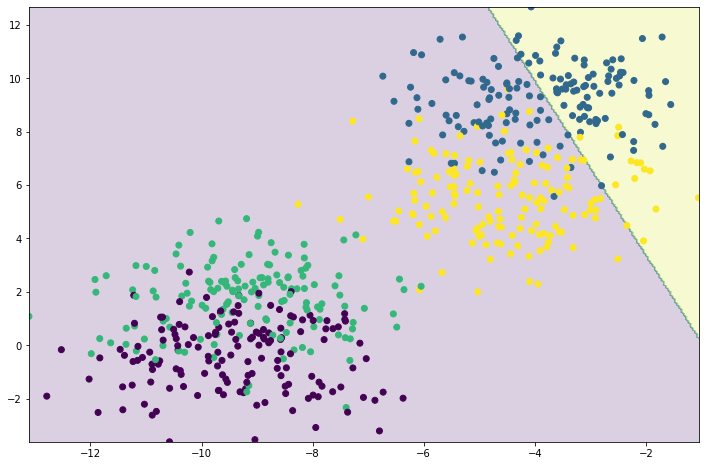

0) Mean loss: 52.56663771502253
1) Mean loss: 49.19630822921167


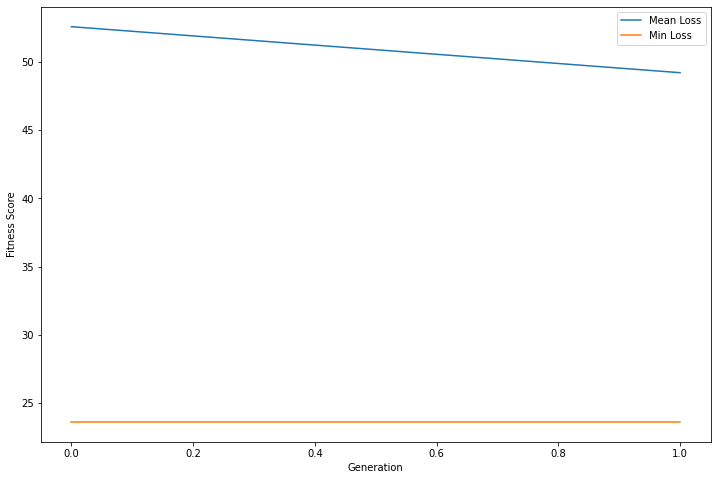

In [10]:
if __name__ == '__main__':
    ga = GA(30, X, y, 15, 0.2)
    ga.draw(plt.subplot(), update=False)
    best_pop = ga.start(2)

    ax = plt.subplot()
    ax.figure.set_figwidth(12)
    ax.figure.set_figheight(8)

    ax.plot(ga.history['mean'])
    ax.plot(ga.history['min'])
    ax.legend(('Mean Loss', 'Min Loss'))
    ax.set(xlabel='Generation', ylabel='Fitness Score')

    plt.show()